In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import inspect
import os
import sys
import time

import paragami
import vittles

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [30]:
fit_dir = '/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/jupyter/fits'

#fitfile = './fits/transformed_gene_regression_df7_degree3_genes700_num_components100_fit.npz'
#fitfile = './fits/transformed_gene_regression_df4_degree3_genes700_num_components30_fit.npz' # ok
#fitfile = 'fits/transformed_gene_regression_df7_degree3_genes700_num_components30_fit.npz'
fitfile = os.path.join(fit_dir, 'transformed_gene_regression_df4_degree3_genes700_num_components30_inflate1.0_shrunkTrue_fit.npz')
#fitfile = os.path.join(fit_dir, 'transformed_gene_regression_df4_degree3_genes7000_num_components30_inflate1.0_shrunkTrue_fit.npz')
with np.load(fitfile) as infile:
    gmm_params_pattern = paragami.get_pattern_from_json(
        str(infile['gmm_params_pattern_json']))
    opt_gmm_params = gmm_params_pattern.fold(
        infile['opt_gmm_params_flat'], free=False)
    prior_params_pattern = paragami.get_pattern_from_json(
        str(infile['prior_params_pattern_json']))
    prior_params = prior_params_pattern.fold(
        infile['prior_params_flat'], free=False)
    kl_hess = infile['kl_hess']
    df = infile['df']
    degree = infile['degree']
    datafile = str(infile['datafile'])
    num_components = int(infile['num_components'])

reg_params = dict()
with np.load(datafile) as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    inflate_cov = infile.get('inflate_cov', 0)
    eb_shrunk = infile.get('eb_shrunk', False)

num_genes = reg_params['beta_mean'].shape[0]

analysis_name = \
    ('transformed_gene_regression_df{}_degree{}_genes{}_' +
     'num_components{}_inflate{}_shrunk{}_refit').format(
    df, degree, num_genes, num_components, inflate_cov, eb_shrunk)

In [3]:
new_alpha = 0.01
new_prior_params = deepcopy(prior_params)
new_prior_params['probs_alpha'][:] = new_alpha

gmm = gmm_lib.GMM(num_components, new_prior_params, reg_params)

print('Setting preconditioner...')
gmm.get_kl_conditioned.set_preconditioner_with_hessian(
    hessian=kl_hess, ev_min=1e-6)
print('Done.')

init_x = gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True)

print('Optimizing...')
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x, verbose=True, kl_hess=kl_hess)
opt_time = time.time() - tic
print('Done.')
print('Re-optimization time: {} seconds'.format(opt_time))

Setting preconditioner...
Done.
Optimizing...
Iter 0: f = -14834.23678839
Preconditioned iteration 1
  Taking Newton step.
Iter 1: f = -14834.23678839
Iter 2: f = -14838.33653764
4.099749249406159
Iter 3: f = -14838.33653764
Success.
  Running preconditioned optimization.
Iter 0: f = -14838.33653764
Iter 1: f = -14839.10541330
Iter 2: f = -14840.04782601
Iter 3: f = -14840.87874137
Iter 4: f = -14841.33822229
Iter 5: f = -14842.06583465
Iter 6: f = -14840.63059148
Iter 7: f = -14841.86681026
Iter 8: f = -14842.16179705
Iter 9: f = -14842.24635231
Iter 10: f = -14842.45246107
Iter 11: f = -14841.64584927
Iter 12: f = -14842.55108260
Iter 13: f = -14842.64033207
Iter 14: f = -14842.76983371
Iter 15: f = -14842.91913973
Iter 16: f = -14842.95627284
Iter 17: f = -14843.14517532
Iter 18: f = -14843.22185356
Iter 19: f = -14843.29955568
Iter 20: f = -14831.80295805
Iter 21: f = -14842.58270412
Iter 22: f = -14843.29914534
Iter 23: f = -14843.39319227
Iter 24: f = -14843.37307119
Iter 25: f =

In [31]:
# Save the refit
reopt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)

save_dict = dict()

save_dict['input_filename'] = fitfile
save_dict['reopt_gmm_params_flat'] = \
    gmm.gmm_params_pattern.flatten(reopt_gmm_params, free=False)
save_dict['reopt_time'] = opt_time
save_dict['gmm_params_pattern_json'] = gmm.gmm_params_pattern.to_json()
save_dict['reopt_kl_hess'] = gmm_opt['kl_hess']
save_dict['reopt_prior_params_flat'] = \
    prior_params_pattern.flatten(gmm.prior_params, free=False)
save_dict['reopt_prior_params_pattern_json'] = \
    prior_params_pattern.to_json()

outfile = './fits/{}.npz'.format(analysis_name)
print('Saving to {}'.format(outfile))

np.savez_compressed(file=outfile, **save_dict)

Saving to ./fits/transformed_gene_regression_df4_degree3_genes7000_num_components30_inflate1.0_shrunkTrue_refit.npz


5.156480099556379

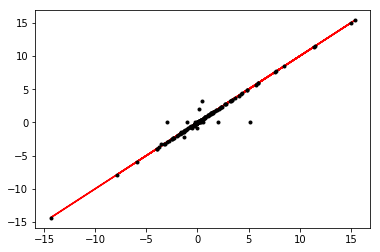

In [4]:
reopt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
def comparison_plot(x, y):
    plt.plot(x, x, 'r')
    plt.plot(x, y, 'k.')
    
comparison_plot(opt_gmm_params['centroids'], reopt_gmm_params['centroids'])
np.max(np.abs((opt_gmm_params['centroids'] - reopt_gmm_params['centroids'])))

0.08560380860726025

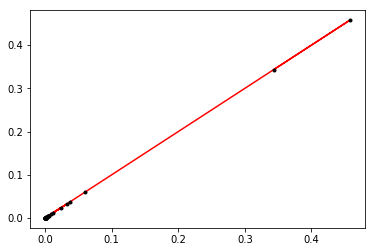

In [5]:
e_z0 = gmm.get_e_z(opt_gmm_params)
e_z1 = gmm.get_e_z(reopt_gmm_params)

comparison_plot(np.mean(e_z0, axis=0), np.mean(e_z1, axis=0))
np.max(np.abs(e_z0 - e_z1))

In [6]:
opt_gmm_params['stick_propn_mean'].shape
num_components

30

In [13]:
from bnpmodeling_runjingdev.cluster_quantities_lib import get_e_num_large_clusters_from_ez
from bnpmodeling_runjingdev.cluster_quantities_lib import get_e_number_clusters_from_logit_sticks

n_samples = 10000
threshold = 1
predictive = True

unif_samples = None
unv_norm_samples = None
if not predictive:
    unif_samples = np.random.random((gmm.num_obs, n_samples))
else:
    unv_norm_samples = np.random.normal(
        0, 1, size = (n_samples, num_components - 1))

def get_posterior_quantity(gmm_params):
    if not predictive:
        e_z = gmm.get_e_z(gmm_params)
        e_num, var_num = get_e_num_large_clusters_from_ez(
            e_z,
            threshold = threshold,
            n_samples = None,
            unif_samples = unif_samples)
    else:
        e_num = \
            get_e_number_clusters_from_logit_sticks(
                gmm_params['stick_propn_mean'],
                gmm_params['stick_propn_info'],
                n_obs = gmm.num_obs,
                threshold = threshold,
                n_samples = None,
                unv_norm_samples = unv_norm_samples)
    return e_num

get_posterior_quantity(opt_gmm_params)

26.79854993136649

In [14]:
e_num0 = get_posterior_quantity(opt_gmm_params)
e_num1 = get_posterior_quantity(reopt_gmm_params)
print('Refit e:\t{}\nOrig e: \t{}\nDifference:\t{}\n'.format(
    e_num1, e_num0, e_num1 - e_num0))

Refit e:	25.034629198397138
Orig e: 	26.79854993136649
Difference:	-1.7639207329693534



In [15]:
prior_free = False

get_kl_from_vb_free_prior_free = \
    paragami.FlattenFunctionInput(original_fun=
        gmm.get_params_prior_kl,
        patterns = [gmm.gmm_params_pattern, prior_params_pattern],
        free = [True, prior_free],
        argnums = [0, 1])

gmm.get_params_prior_kl(opt_gmm_params, prior_params)

get_kl_from_vb_free_prior_free(
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True),
    prior_params_pattern.flatten(prior_params, free=prior_free))

-14817.084024805998

In [16]:
taylor_order = 1
t0 = time.time()
vb_sens = \
    vittles.ParametricSensitivityTaylorExpansion(
        objective_function =    get_kl_from_vb_free_prior_free,
        input_val0 =            gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True),
        hyper_val0 =            prior_params_pattern.flatten(prior_params, free=prior_free),
        order =                 taylor_order,
        hess0 =                 kl_hess)
print('linear response Hessian time: {:.03f} secs'.format(time.time() - t0))

linear response Hessian time: 0.002 secs


In [17]:
predict_gmm_params = \
    paragami.FoldFunctionInputAndOutput(
        original_fun=vb_sens.evaluate_taylor_series,
        input_patterns=prior_params_pattern,
        input_free=prior_free,
        input_argnums=[0],
        output_patterns=gmm.gmm_params_pattern,
        output_free=True,
        output_retnums=[0])

pred_gmm_params = predict_gmm_params(new_prior_params)

e_num_pred = get_posterior_quantity(pred_gmm_params)

print('Orig e: \t{}\nRefit e:\t{}\nPred e:\t\t{}\nActual diff:\t{:0.5}\nPred diff:\t{:0.5}'.format(
    e_num0, e_num1, e_num_pred,
    e_num1 - e_num0,
    e_num_pred - e_num0))

Orig e: 	26.79854993136649
Refit e:	25.034629198397138
Pred e:		24.57521211004247
Actual diff:	-1.7639
Pred diff:	-2.2233
